# Настройки

In [1]:
import os
import shutil
import zipfile

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import PIL
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision.utils import save_image

В корневой папке с проектом, хранятся два zip-архива: monet_jpg.zip и photo_jpg.zip

In [ ]:
def unzip_file(photo_path, photo_directory_to_save):
    with zipfile.ZipFile(photo_path, 'r') as zip_ref:
        zip_ref.extractall(photo_directory_to_save)

In [ ]:
PATH_TO_PROJECT = "D:/1.Code/4Tinkoff/2. Тинкофф DL/6. GAN"
DIRECTORY_PHOTO = "photo_jpg"
DIRECTORY_MONET = "monet_jpg"

In [ ]:
unzip_file(os.path.join(PATH_TO_PROJECT, "monet_jpg.zip"), os.path.join(PATH_TO_PROJECT, DIRECTORY_MONET))
unzip_file(os.path.join(PATH_TO_PROJECT, "photo_jpg.zip"), os.path.join(PATH_TO_PROJECT, DIRECTORY_PHOTO))

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
set_seed(42)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Обработка данных

In [6]:
class ImageDataset(Dataset):
    def __init__(self, monet_path, photo_path):
        self.monet_path = monet_path
        self.photo_path = photo_path

        self.monet_images = os.listdir(monet_path)
        self.photo_images = os.listdir(photo_path)

        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return max(len(self.monet_images), len(self.photo_images))

    def __getitem__(self, index):
        monet_i = self.monet_images[index % len(self.monet_images)]
        photo_i = self.photo_images[index % len(self.photo_images)]

        monet_img = Image.open(os.path.join(self.monet_path, monet_i)).convert("RGB")
        photo_img = Image.open(os.path.join(self.photo_path, photo_i)).convert("RGB")

        return self.transform(photo_img), self.transform(monet_img)

In [7]:
image_dataset = ImageDataset('monet_jpg', 'photo_jpg')
image_loader = DataLoader(image_dataset, batch_size=1, pin_memory=True)

In [8]:
photo_img, monet_img = next(iter(image_loader))
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)
        
    return img

In [32]:
def draw_picture(photo_img, monet_img):
    f = plt.figure(figsize=(8, 8))

    f.add_subplot(1, 2, 1)
    plt.title('Photo')
    photo_img = unnorm(photo_img)
    plt.imshow(photo_img[0].permute(1, 2, 0))

    f.add_subplot(1, 2, 2)
    plt.title('Monet')
    monet_img = unnorm(monet_img)
    plt.imshow(monet_img[0].permute(1, 2, 0))

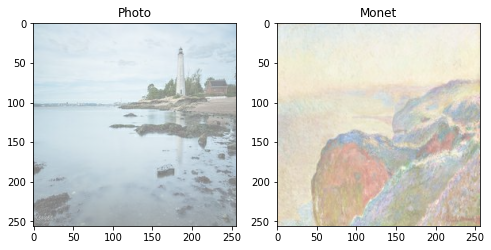

In [33]:
draw_picture(photo_img, monet_img)

# Модель

## Дискриминатор

In [10]:
class BlockDiscriminator(nn.Module):
    def __init__(self, in_channels, out_channels, stride, use_instance_norm=True):
        super().__init__()

        if use_instance_norm:
            self.conv = nn.Sequential(
              nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
              nn.InstanceNorm2d(out_channels),
              nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            self.conv = nn.Sequential(
              nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
              nn.LeakyReLU(0.2, inplace=True),
            )
    
    def forward(self, x):
        return self.conv(x)


In [11]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, list_out_channels=[64, 128, 256, 512]):
        super().__init__()
        self.initial = BlockDiscriminator(in_channels, list_out_channels[0], 2, False)

        layers = []
        current_in_channels = list_out_channels[0]

        for out_channels in list_out_channels[1:]:
            stride = 2
            if out_channels == list_out_channels[-1]:
                stride = 1

        layers.append(BlockDiscriminator(current_in_channels, out_channels, stride=stride))
        current_in_channels = out_channels

        layers.append(nn.Conv2d(current_in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return torch.sigmoid(self.model(self.initial(x)))


## Генератор

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_activate=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, padding_mode="reflect", kernel_size=3, **kwargs)
          if down 
          else nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, **kwargs),
          nn.InstanceNorm2d(out_channels),
          nn.ReLU() if use_activate else nn.Identity()
        )
  
    def forward(self, x):
        return self.conv(x)

In [13]:
class GeneratorBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            ConvBlock(channels, channels, padding=1),
            ConvBlock(channels, channels, use_activate=False, padding=1),
        )
  
    def forward(self, x):
        return x + self.conv(x)

In [14]:
class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),

            ConvBlock(num_features, num_features*2, stride=2, padding=1),
            ConvBlock(num_features*2, num_features*4, stride=2, padding=1),

            *[GeneratorBlock(num_features*4) for _ in range(5)],

            ConvBlock(num_features*4, num_features*2, down=False, stride=2, padding=1, output_padding=1),
            ConvBlock(num_features*2, num_features*1, down=False, stride=2, padding=1, output_padding=1),

            nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")
        )
  
    def forward(self, x):
        return torch.tanh(self.model(x)) 


# Обучение модели

In [59]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [60]:
def draw_gen_picture(gan, count):
    _, ax = plt.subplots(count, 2, figsize=(12, 12))
    i = 0

    for photo_img, _ in image_loader:
        pred_monet = gan.generator_monet(photo_img.to(device)).cpu().detach()
        photo_img = unnorm(photo_img)
        pred_monet = unnorm(pred_monet)

        ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
        ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-esque Photo")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
        i += 1
        if i == count:
            break
    plt.show()

In [61]:
class CycleGAN:
    def __init__(self, in_ch, out_ch, epochs, lmbda=10, id_coef=0.5):
        
        self.epochs = epochs
        self.lmbda = lmbda
        self.id_coef = id_coef

        self.generator_photo = Generator(in_ch, out_ch).to(device)
        self.generator_monet = Generator(in_ch, out_ch).to(device)
        self.discriminator_monet = Discriminator(in_ch).to(device)
        self.discriminator_photo = Discriminator(in_ch).to(device)

        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()

        self.adam_gen = torch.optim.Adam(
            list(self.generator_photo.parameters()) + list(self.generator_monet.parameters()),
            lr=2e-4, betas=(0.5, 0.999))
        self.adam_desc = torch.optim.Adam(
            list(self.discriminator_monet.parameters()) + list(self.discriminator_photo.parameters()),
            lr=2e-4, betas=(0.5, 0.999))

    def train(self, photo_loader):
        for epoch in range(self.epochs):
            avg_gen_loss = 0.0
            avg_desc_loss = 0.0
            t = tqdm(photo_loader, leave=False, total=photo_loader.__len__())

            for image_photo, image_monet in t:
                image_photo, image_monet = image_photo.to(device), image_monet.to(device)
                
                # Тренируем генератор 
                update_req_grad([self.discriminator_monet, self.discriminator_photo], False)
                self.adam_gen.zero_grad()

                fake_photo = self.generator_photo(image_monet)
                fake_monet = self.generator_monet(image_photo)

                cycl_monet = self.generator_monet(fake_photo)
                cycl_photo = self.generator_photo(fake_monet)
                
                id_monet = self.generator_monet(image_monet)
                id_photo = self.generator_photo(image_photo)

                # Считаем лосс генератора
                id_loss_monet = self.l1_loss(id_monet, image_monet) * self.lmbda * self.id_coef
                id_loss_photo = self.l1_loss(id_photo, image_photo) * self.lmbda * self.id_coef

                cycle_loss_monet = self.l1_loss(cycl_monet, image_monet) * self.lmbda
                cycle_loss_photo = self.l1_loss(cycl_photo, image_photo) * self.lmbda

                monet_desc = self.discriminator_monet(fake_monet)
                photo_desc = self.discriminator_photo(fake_photo)

                real = torch.ones(monet_desc.size()).to(device)

                adv_loss_monet = self.mse_loss(monet_desc, real)
                adv_loss_photo = self.mse_loss(photo_desc, real)
                
                # Итоговый лосс генератора 
                total_gen_loss = cycle_loss_monet + adv_loss_monet \
                                 + cycle_loss_photo + adv_loss_photo \
                                 + id_loss_monet + id_loss_photo

                avg_gen_loss += total_gen_loss.item()

                total_gen_loss.backward()
                self.adam_gen.step()
                
                # Тренируем дискриминатор 
                update_req_grad([self.discriminator_monet, self.discriminator_photo], True)
                self.adam_desc.zero_grad()

                fake_monet = torch.tensor(fake_monet.cpu().data.numpy()).to(device)
                fake_photo = torch.tensor(fake_photo.cpu().data.numpy()).to(device)

                monet_desc_real = self.discriminator_monet(image_monet)
                monet_desc_fake = self.discriminator_monet(fake_monet)
                
                photo_desc_real = self.discriminator_photo(image_photo)
                photo_desc_fake = self.discriminator_photo(fake_photo)

                real = torch.ones(monet_desc_real.size()).to(device)
                fake = torch.zeros(monet_desc_fake.size()).to(device)

                # Считаем лосс дискриминатора
                monet_desc_real_loss = self.mse_loss(monet_desc_real, real)
                monet_desc_fake_loss = self.mse_loss(monet_desc_fake, fake)
                photo_desc_real_loss = self.mse_loss(photo_desc_real, real)
                photo_desc_fake_loss = self.mse_loss(photo_desc_fake, fake)

                monet_desc_loss = (monet_desc_real_loss + monet_desc_fake_loss) / 2
                photo_desc_loss = (photo_desc_real_loss + photo_desc_fake_loss) / 2
                
                # Итоговый лосс дискриминатора
                total_desc_loss = monet_desc_loss + photo_desc_loss
                avg_desc_loss += total_desc_loss.item()

                # backward()
                monet_desc_loss.backward()
                photo_desc_loss.backward()
                self.adam_desc.step()

                t.set_postfix(gen_loss=round(total_gen_loss.item(), 2), desc_loss=round(total_desc_loss.item(), 2))

            avg_gen_loss /= photo_loader.__len__()
            avg_desc_loss /= photo_loader.__len__()

            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" %
                  (epoch + 1, avg_gen_loss, avg_desc_loss))
            
            draw_gen_picture(self, 2)

            

Epoch: (1) | Generator Loss:8.682887 | Discriminator Loss:0.208946


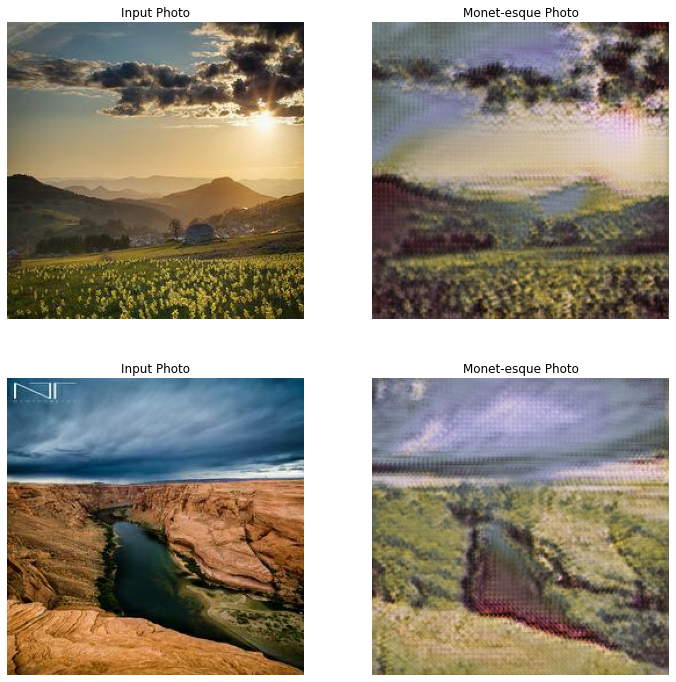

Epoch: (2) | Generator Loss:7.949224 | Discriminator Loss:0.133542


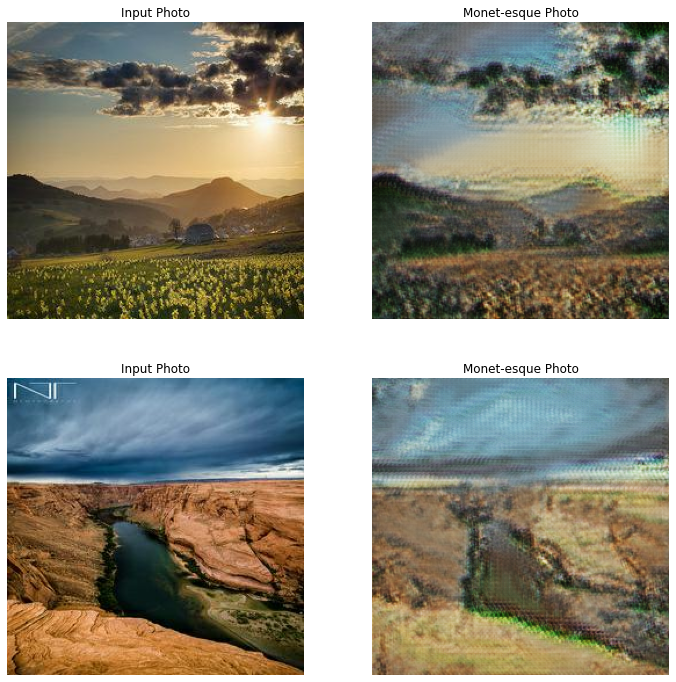

Epoch: (3) | Generator Loss:7.783966 | Discriminator Loss:0.117272


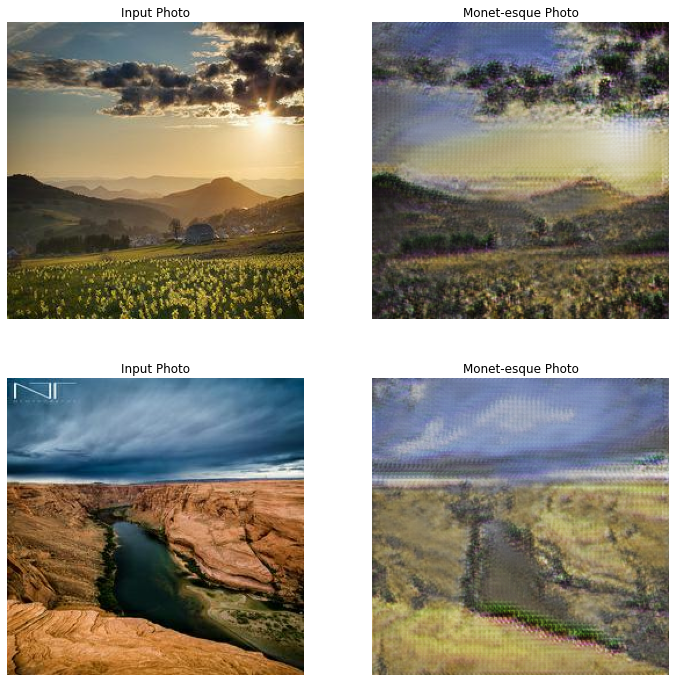

Epoch: (4) | Generator Loss:7.665496 | Discriminator Loss:0.096390


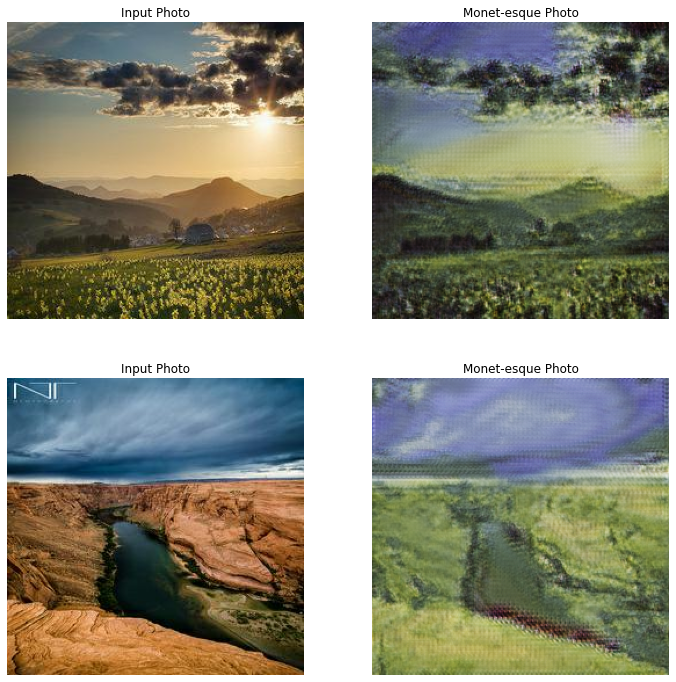

Epoch: (5) | Generator Loss:7.587823 | Discriminator Loss:0.077843


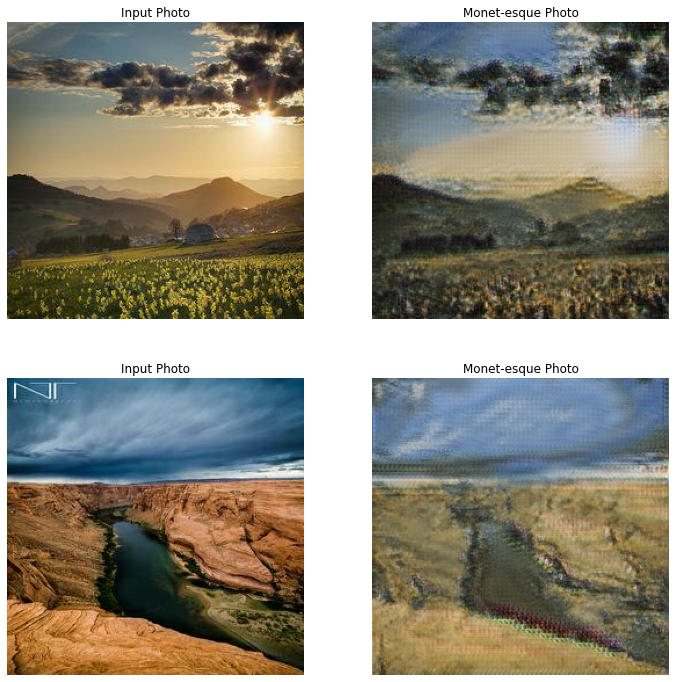

Epoch: (6) | Generator Loss:7.504965 | Discriminator Loss:0.068729


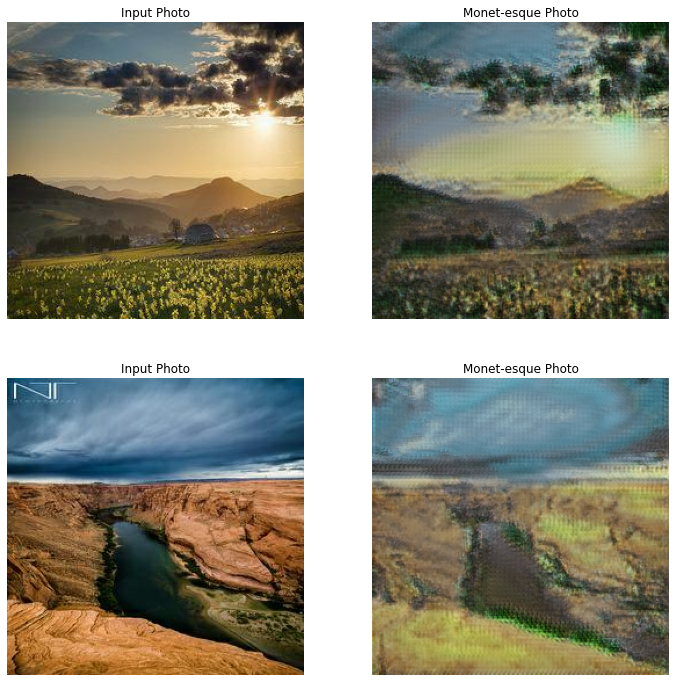

Epoch: (7) | Generator Loss:7.436189 | Discriminator Loss:0.057844


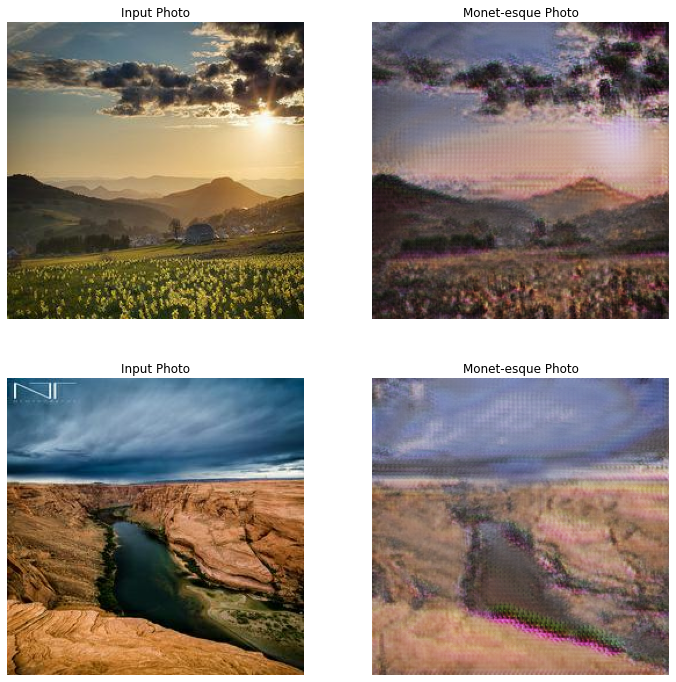

Epoch: (8) | Generator Loss:7.355345 | Discriminator Loss:0.053458


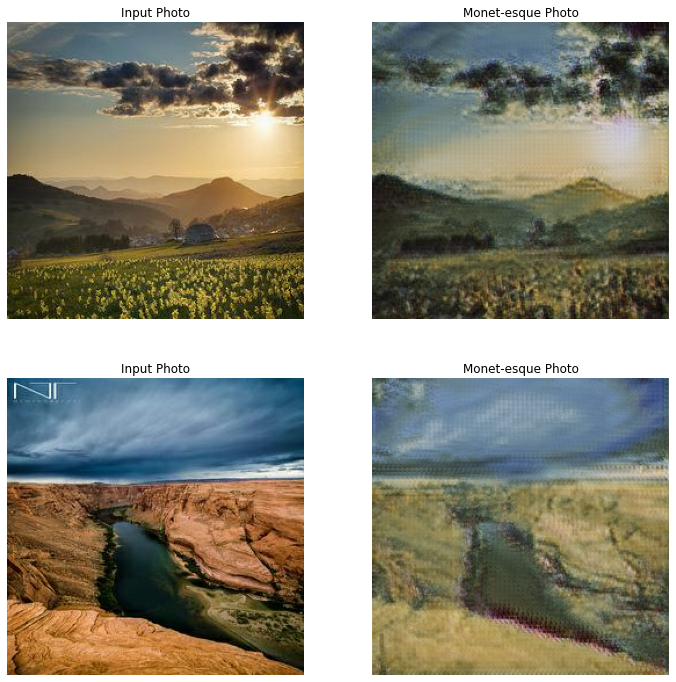

Epoch: (9) | Generator Loss:7.299947 | Discriminator Loss:0.045321


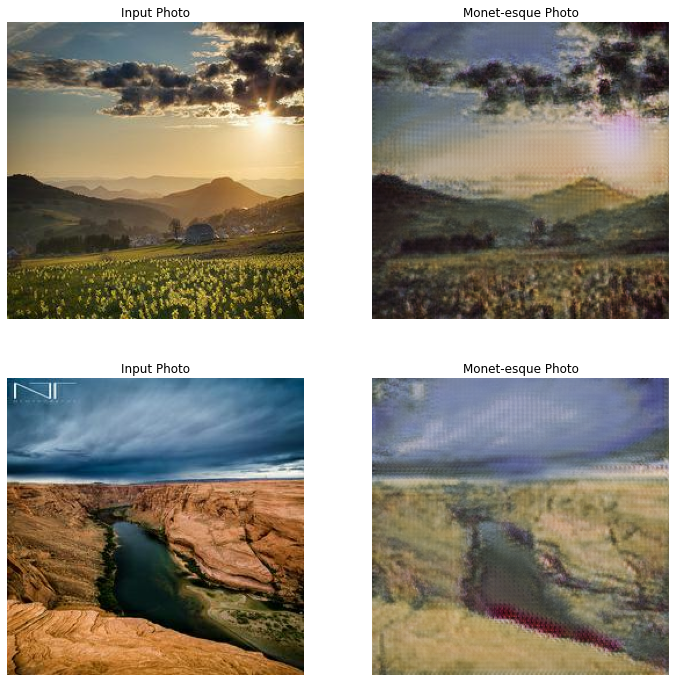

Epoch: (10) | Generator Loss:7.232851 | Discriminator Loss:0.042130


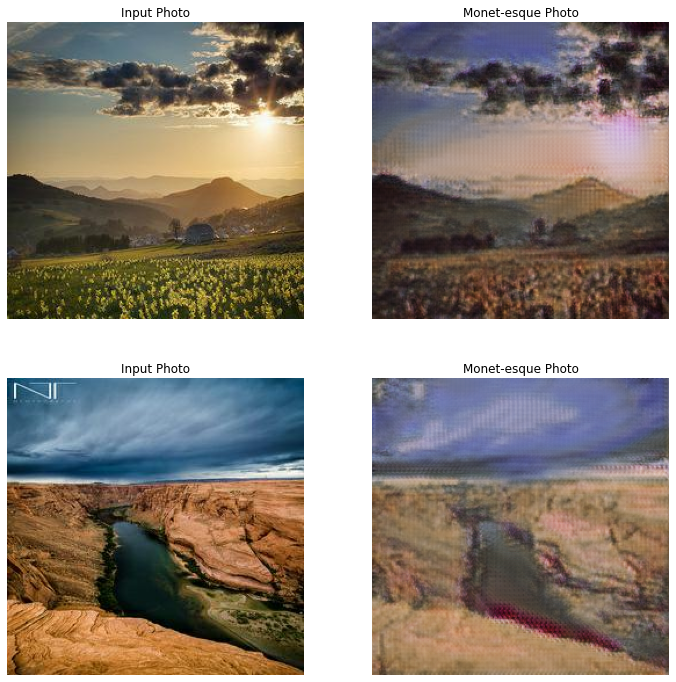

In [62]:
gan = CycleGAN(3, 3, 10)
gan.train(image_loader)

# Результат

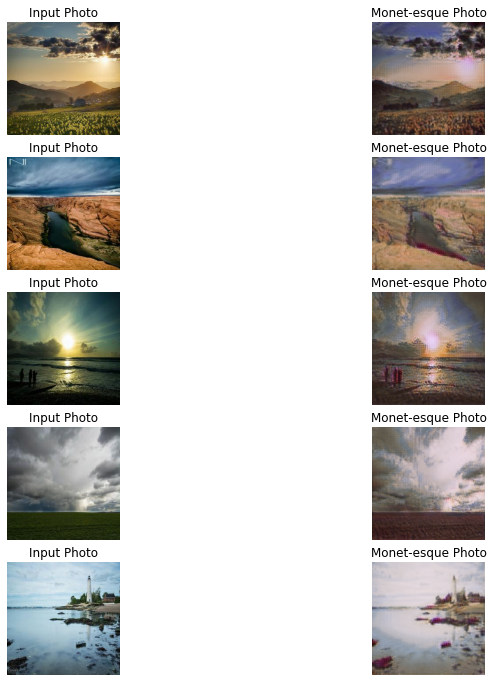

In [64]:
draw_gen_picture(gan, 5)

На Kaggle залить не получилось - не смог подтвердить номер телефона